<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterator

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta
import os
import re

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from collections import defaultdict
from functools import reduce

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'sample-sales-data.csv',
 'sales.csv',
 'test.csv',
 'scanner_data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'KPMG_VI_New_raw_data_update_final.csv',
 'mock_sales_data.csv',
 'online_retail_II.xlsx',
 'online_retail.xlsx',
 '1_order_payments_dataset.csv',
 '1_customers_dataset.csv',
 'sales_vs_discount.csv',
 'ecommerce-data.csv',
 'sales_data_with_stores.csv',
 'groceries.csv',
 'mall_customers.csv',
 '1_orders_dataset.csv',
 'sample_data']

In [7]:
df = pd.read_csv('ecommerce-data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.columns = [''.join(re.split(r'(?=[A-Z][a-z])', a)).lower() for a in df.columns]
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [11]:
df = df[(~df.invoiceno.str.contains('C'))&(df.country == 'United Kingdom')]
df.invoicedate = pd.to_datetime(df.invoicedate)
df['date'] = df.invoicedate.to_numpy().astype('datetime64[D]')
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df['rev'] = df.quantity * df.unitprice
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,rev,date,month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01


In [12]:
df = df.groupby(['month', 'date', 'customerid'])['rev'].sum().reset_index()
df.head()

,month,date,customerid,rev
0,2010-12-01,2010-12-01,12748.0,4.95
1,2010-12-01,2010-12-01,12838.0,390.79
2,2010-12-01,2010-12-01,12868.0,203.30
3,2010-12-01,2010-12-01,12921.0,322.40
4,2010-12-01,2010-12-01,12947.0,304.04


In [29]:
info_m = df.groupby(['customerid', 'month'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index = 'customerid', columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = 'customerid', var_name = 'month', value_name = 'money').sort_values(['customerid','month'], ascending = [1,0])
info_m = info_m.groupby(['customerid']).head(3)
info_m = info_m.groupby(['customerid'])['money'].sum().reset_index()
info_m.head()

,customerid,money
0,12346.0,0.00
1,12747.0,1426.61
2,12748.0,14002.34
3,12749.0,1335.65
4,12820.0,554.11


In [23]:
info_f = df.groupby(['customerid', 'month'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = 'customerid', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = 'customerid', var_name = 'month', value_name = 'freq').sort_values(['customerid','freq'], ascending = [1,0])
info_f = info_f.groupby(['customerid']).head(3)
info_f = info_f.groupby(['customerid'])['freq'].sum().reset_index()
info_f.head()

,customerid,freq
0,12346.0,1.0
1,12747.0,5.0
2,12748.0,43.0
3,12749.0,3.0
4,12820.0,3.0


In [27]:
max_date = df['date'].max() + pd.offsets.BMonthEnd(0)
max_date

Timestamp('2011-12-30 00:00:00')

In [34]:
info_r = df.groupby(['customerid']).agg({'date' : lambda x : (max_date - x.max())}).reset_index().rename(columns = {'date':'recency'})
info_r['recency'] = info_r['recency'].dt.days
info_r.head()

,customerid,recency
0,12346.0,346
1,12747.0,23
2,12748.0,21
3,12749.0,24
4,12820.0,24


In [35]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'customerid'), info_m, 'left', 'customerid')
info.head()

,customerid,recency,freq,money
0,12346.0,346,1.0,0.00
1,12747.0,23,5.0,1426.61
2,12748.0,21,43.0,14002.34
3,12749.0,24,3.0,1335.65
4,12820.0,24,3.0,554.11


In [36]:
info = info.assign(
    r = pd.qcut(info.recency, 5, list('12345')),
    f = pd.qcut(info.freq.rank(method = 'first'), 5, list('54321')),
    m = pd.qcut(info.money.rank(method = 'first'), 5, list('54321'))
)
info.head()

,customerid,recency,freq,money,r,f,m
0,12346.0,346,1.0,0.00,5,5,5
1,12747.0,23,5.0,1426.61,1,1,1
2,12748.0,21,43.0,14002.34,1,1,1
3,12749.0,24,3.0,1335.65,1,3,1
4,12820.0,24,3.0,554.11,1,3,2


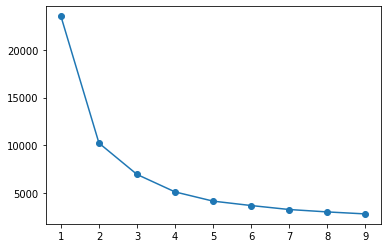

In [44]:
def get_elbow() :

  res = []

  for i in range(1,10) :
    km = KMeans(n_clusters = i)
    km.fit(info[['r','f','m']])
    res.append(km.inertia_)
  
  plt.plot(range(1,10), res, marker = 'o')
  plt.show()

get_elbow()

In [45]:
km = KMeans(n_clusters = 4)
km.fit(info[['r', 'f', 'm']])
info['flag'] = km.fit_predict(info[['r','f','m']]).astype(str)
info.head()

,customerid,recency,freq,money,r,f,m,flag
0,12346.0,346,1.0,0.00,5,5,5,1
1,12747.0,23,5.0,1426.61,1,1,1,0
2,12748.0,21,43.0,14002.34,1,1,1,0
3,12749.0,24,3.0,1335.65,1,3,1,0
4,12820.0,24,3.0,554.11,1,3,2,2


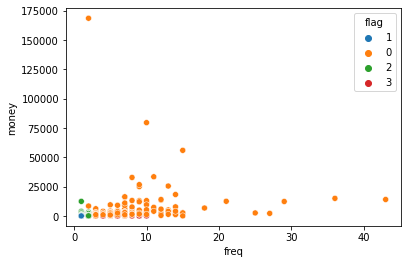

In [48]:
sns.scatterplot(data = info, x = 'freq', y = 'money', hue = 'flag')

In [50]:
info2 = pd.melt(info[['customerid', 'flag','r', 'f', 'm']], id_vars=['customerid','flag'])
info2.head()

,customerid,flag,variable,value
0,12346.0,1,r,5
1,12747.0,0,r,1
2,12748.0,0,r,1
3,12749.0,0,r,1
4,12820.0,2,r,1


/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_density.py:153: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_density.py:155: PlotnineWarning: Groups with fewer than 2 data points have been removed.


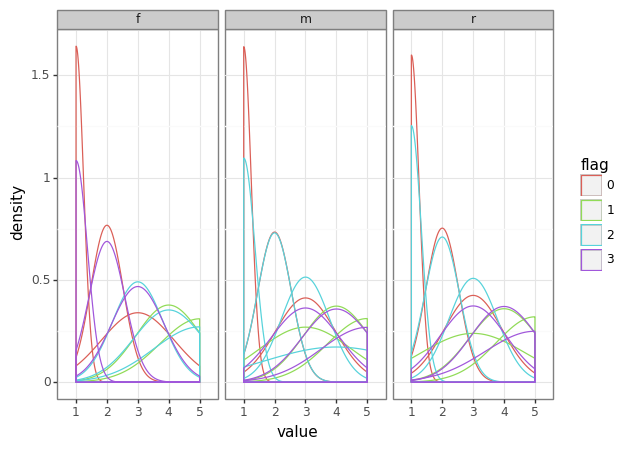

<ggplot: (8792505396861)>

In [52]:
(
    ggplot(info2, aes('value', color = 'flag')) +
    gg.geom_density() +
    gg.facet_wrap('~variable') +
    gg.theme_bw()
)

In [54]:
import plotly.express as px

In [60]:
px.scatter_3d(info, x = 'r', y = 'f', z = 'm', color = 'flag', size_max = 0.1)

In [61]:
px.scatter_3d(info, x = 'recency', y = 'freq', z = 'money', color = 'flag', size_max = 0.1)

# Iterator

In [63]:
from string import ascii_lowercase as ll
chr = list(ll) + list(range(10))

In [69]:
names = ['park', 'oh', 'kang']
email1 = [''.join(np.random.choice(chr, 10, replace = True)) for a in range(3)]
email2 = [''.join(np.random.choice(chr, 5, replace = True)) for a in range(3)]
email = [a + '@' + b + np.random.choice(['.com','.net','.co.kr'],1)[0] for a, b in zip(email1, email2)]
age = np.random.randint(20, 40, 3)

In [70]:
print(names)
print(email)
print(age)

['park', 'oh', 'kang']
['j1gdsuq87p@kyhk1.net', 'nvhr9unkhp@nqozf.co.kr', 'woom6z6end@sv42w.net']
[30 38 30]


In [75]:
[{a : [b, c]} for a, b, c in zip(names, email, age)]

[{'park': ['j1gdsuq87p@kyhk1.net', 30]},
 {'oh': ['nvhr9unkhp@nqozf.co.kr', 38]},
 {'kang': ['woom6z6end@sv42w.net', 30]}]

In [76]:
[[a, b, c] for a, b, c in zip(names, email, age)]

[['park', 'j1gdsuq87p@kyhk1.net', 30],
 ['oh', 'nvhr9unkhp@nqozf.co.kr', 38],
 ['kang', 'woom6z6end@sv42w.net', 30]]

In [79]:
[{'name' : a, 'mail' : b, 'age' : c} for a, b, c in zip(names, email, age)]

[{'name': 'park', 'mail': 'j1gdsuq87p@kyhk1.net', 'age': 30},
 {'name': 'oh', 'mail': 'nvhr9unkhp@nqozf.co.kr', 'age': 38},
 {'name': 'kang', 'mail': 'woom6z6end@sv42w.net', 'age': 30}]